## Test class wrapper

In dypy we are able to define classes that contain objects with different implementations of the same method. This is useful when we want to introduce an experiment class that uses methods to run experiments, but each experiment might have different configurations. The most generic form of creating all these different configurations is to have a certain set of methods that are implemented differently per each of the instances.

In this notebook, we will briefly cover this functionality with a dummy example.

In [1]:
import sys

sys.path.append('..')

### Use-Case: Generic Simulations

Now let's leverage the dynamic wrappers for running a physical simulation. We will show using this dummy example that a simulation can be implemented in the most generic case. For illustration, we will consider the throwing ball problem where we want to throw a ball on with an initial velocity and angle and check the trajectory that the ball takes in space. This can be simply done using the following set of forumalas in the ideal non-friction case:

* $x = v_0 \times t \sin(\theta)$
* $y = v_0 \times t \cos(\theta) - \frac{1}{2} g t^2$ where $g$ is the gravitational acceleration.

Now lets assume that we have wind blowing from $x = +\infty$ to $x = -\infty$ uniformly and horizontally inducing some acceleration on the ball denoted by $a_{wind}(t)$. 
For simplicity, we will assume that the acceleration induced by the windspeed has the following simple relation where $v_{wind}(t)$ is the wind speed at a given time:
$$a_{wind}(t) = \frac{f_{wind}(t)}{m} = \frac{(v_{horizontal}(t) + v_{wind}(t)) \cdot s \cdot \mu_{air}}{m}.$$
Where $\mu_{air}$ is a frictional constant of air, $s$ is the object's leading surface, and $v_{horizontal}(t)$ is the speed in the horizontal direction. 

Now to simulate this in a discrete manner, we keep track of the positions $(x(t), y(t))$, velocities in each direction $(v_{hozidontal}(t), v_{vertical}(t))$ and the accelerations $(a_{horizontal}(t), a_{vertical}(t)) = (a_{wind}(t), g)$. With that in mind, using a small enough time step $\Delta$ we update the positions according to the velocity and update the velocity according to the acceleration values.

The following simulator object summarizes what we just mentioned: 
 


In [2]:
import numpy as np
import typing as th
import matplotlib.pyplot as plt
from IPython.display import clear_output


class BallSimulator:
    """
    A simulator for throwing a ball with mass "m" and surface area "s" in the air from point (0, 0) 
    in the x-y plane with a given initial velocity and angle (v0, theta0).
    """
    
    def __init__(self, m: float, s: float, v0: float, theta0 : float, 
                 g : float = 9.81, v_wind: float = 3, friction_constant : float = 1):
        self.m = m
        self.s = s
        self.g = g
        self.v0 = v0
        self.theta0 = theta0
        self.x = 0
        self.y = 0
        self.t = 0
        self.v_wind = v_wind
        self.friction_constant = friction_constant
    
    def get_wind_friction_acceleration(self, v: float) -> float:
        return self.friction_constant * v * self.s / self.m

    def _real_simulation(self) -> th.List:
        simulation = []

        gravity_acceleration = self.g
        
        simulation.append((self.x, self.y))

        # get the current speed
        current_speed_x = self.v0 * np.cos(self.theta0)
        current_speed_y = self.v0 * np.sin(self.theta0)

        while True:
            delta_t = 0.05

            # update the position according to the current speed
            self.x += delta_t * current_speed_x
            self.y += delta_t * current_speed_y

            # update the speed according to the current acceleration
            current_speed_x -= self.get_wind_friction_acceleration(current_speed_x + self.v_wind) * delta_t
            current_speed_y -= gravity_acceleration * delta_t
            
            self.t += delta_t
            
            simulation.append((self.x, max(0, self.y)))
        
            if self.y < 0:
                break
            
        return simulation
        
    def simulate(self):
        simulation_list = self._real_simulation()
        
        all_xs = [x for x, y in simulation_list]
        all_ys = [y for x, y in simulation_list]
        # get the maximum 'x' value in the simulation
        max_x = max(all_xs) + 1
        min_x = min(all_xs) - 1
        # get the maximum 'y' value in the simulation
        max_y = max(all_ys) + 1
        min_y = min(all_ys) - 0.25
        # create a matplotlib figure of size max_x and max_y
        for x, y in simulation_list:
            plt.plot(all_xs, all_ys, c='orange')
            # plot a line from (min_x, 0) to (max_x, 0)
            plt.plot([min_x, max_x], [min(all_ys), min(all_ys)], c='black')
            plt.scatter(x, y, c='b')
            plt.xlim(min_x, max_x)
            plt.ylim(min_y, max_y)
        
            plt.show()
            clear_output(wait=True)
        # close the figure
        plt.close()




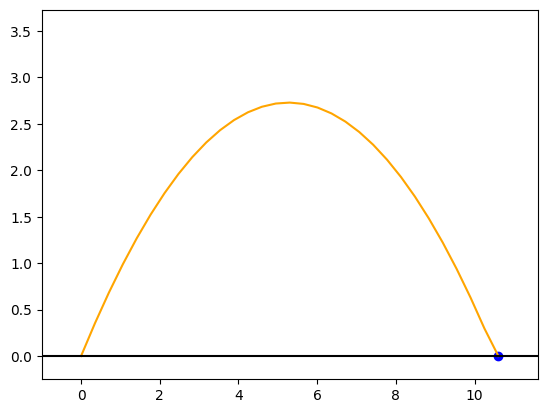

In [3]:
# simulation without friction
simul = BallSimulator(m=1, s=1, v0=10, theta0=np.pi/4, v_wind=0, friction_constant=0)
simul.simulate()

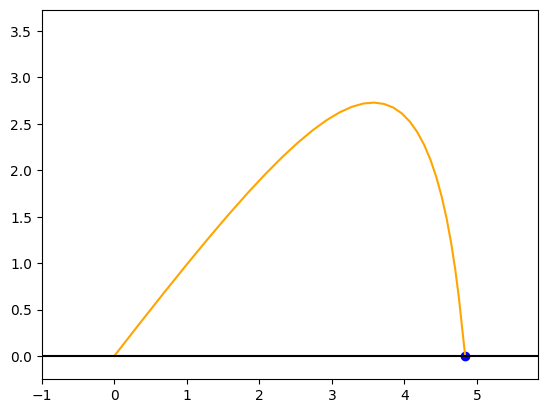

In [4]:
# simulation with friction
simul = BallSimulator(m=1, s=1, v0=10, theta0=np.pi/4, v_wind=1, friction_constant=1)
simul.simulate()

#### Generic Dynamic Wrappers

The problem with the simulator object above is that even though values such as $g$ and $\mu_{friction}$ are typically constant, we have to handle them in the constructor resulting in a large an unreadable constructor code. In other words, each experiment contains a set of tunable knobs and to make the simulator as generic as possible you may need to add a lot of field attributes resulting in a messy and unreadable constructor.

Imagine running multiple experiments on your system only to find out that a very specific set of configurations work. You can either delete the rest of the code for further readability which would result in losing your implementation; or you could leave the code as is which will result in the next person reading the code to glance at a lot of irrelevent code configurations.

`dypyWrappers` are a way to deal with this compromise and provide code that is readable and at the same time generic. To do so, we will first define a wrapper for a set of generic fields and then introduce a wrapper for generic methods.

#### Field Wrappers

Using `dypy.wrappers.dynamize` we can setup a lot of these constant knobs to be dynamic fields which we can leave as is or set them in the constructor. For example, check out the re-written version of the simulation code below:

In [5]:
import numpy as np
import typing as th
import matplotlib.pyplot as plt
from IPython.display import clear_output
import dypy as dy

@dy.dynamize
class BallSimulator:
    """
    A simulator for throwing a ball with mass "m" and surface area "s" in the air from point (0, 0) 
    in the x-y plane with a given initial velocity and angle (v0, theta0).
    """
    g = dy.field(9.81)
    v_wind = dy.field(1)
    friction_constant = dy.field(1)
    delta_t = dy.field(0.05)
    x = dy.field(0)
    t = dy.field(0)
    y = dy.field(0)

    def __init__(self, m: float, s: float, v0: float, theta0 : float):
        self.m = m
        self.s = s
        self.v0 = v0
        self.theta0 = theta0
    
    def get_wind_friction_acceleration(self, v: float) -> float:
        return self.friction_constant * v * self.s / self.m

    def _real_simulation(self) -> th.List:
        simulation = []

        gravity_acceleration = self.g
        
        simulation.append((self.x, self.y))

        # get the current speed
        current_speed_x = self.v0 * np.cos(self.theta0)
        current_speed_y = self.v0 * np.sin(self.theta0)

        while True:
            # set this to be customizable
            delta_t = self.delta_t

            # update the position according to the current speed
            self.x += delta_t * current_speed_x
            self.y += delta_t * current_speed_y

            # update the speed according to the current acceleration
            current_speed_x -= self.get_wind_friction_acceleration(current_speed_x + self.v_wind) * delta_t
            current_speed_y -= gravity_acceleration * delta_t
            
            self.t += delta_t
            
            simulation.append((self.x, max(0, self.y)))
        
            if self.y < 0:
                break
            
        return simulation

        
    def simulate(self):
        simulation_list = self._real_simulation()
        
        all_xs = [x for x, y in simulation_list]
        all_ys = [y for x, y in simulation_list]
        # get the maximum 'x' value in the simulation
        max_x = max(all_xs) + 1
        min_x = min(all_xs) - 1
        # get the maximum 'y' value in the simulation
        max_y = max(all_ys) + 1
        min_y = min(all_ys) - 0.25
        # create a matplotlib figure of size max_x and max_y
        for x, y in simulation_list:
            plt.plot(all_xs, all_ys, c='orange')
            # plot a line from (min_x, 0) to (max_x, 0)
            plt.plot([min_x, max_x], [min(all_ys), min(all_ys)], c='black')
            plt.scatter(x, y, c='b')
            plt.xlim(min_x, max_x)
            plt.ylim(min_y, max_y)
        
            plt.show()
            clear_output(wait=True)
        # close the figure
        plt.close()
    




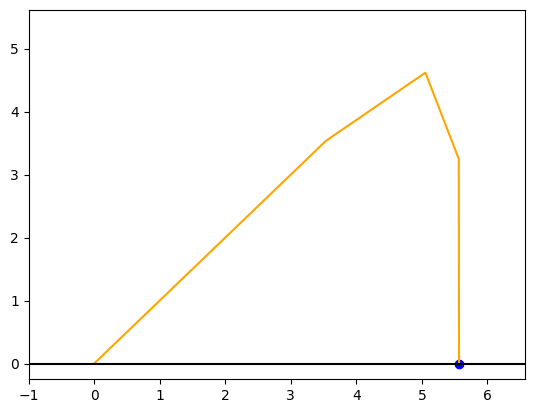

In [6]:
# This is a faster simulator with a non-smooth trajectory
BallSimulator(1, 1, 10, 0.25 * np.pi, delta_t=dy.field(0.5)).simulate()

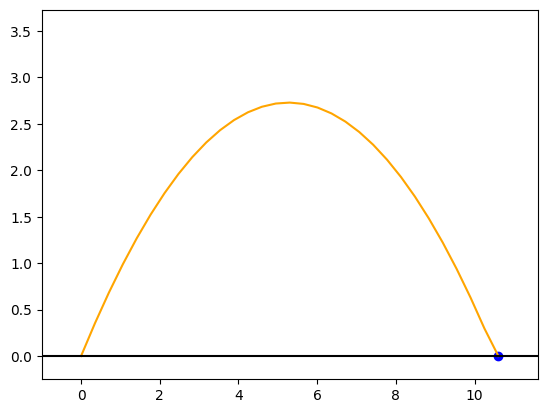

In [7]:
# No friction
BallSimulator(1, 1, 10, 0.25 * np.pi, friction_constant=dy.field(0)).simulate()

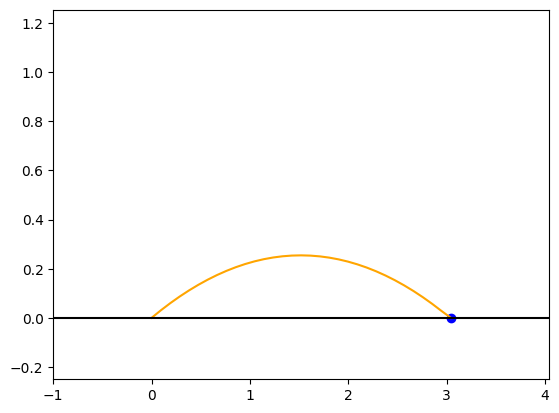

In [8]:
# High gravity and less angle

BallSimulator(1, 1, 10, 0.1 * np.pi, 
            friction_constant=dy.field(0), g=dy.field(20), delta_t=dy.field(0.01)).simulate()

#### Method Wrappers

Now let's say you want to quickly consider the case where the wind speed changes according to time, in that case, you would want to create a method `get_windspeed` that returns the current windspeed. This can act as a scheduler on the windspeed. Conventionally, for any type of scheduler, you should create a separate object and parametrize it and pass the parameters to the constructor of the simulation. However, this introduces the following issues:
1. A large constructor that takes in all the parameters of a simulation and reduces readability.
2. For any type of simulation with different schedulers you might need to create a separate class that inherits the simulator class.
With that in mind, one alternative to the second problem is to write down different scheduler functions in python and pass them as an argument so that a fully generic version of an instance is made. However, using the dynamic class decorator `dypy.wrappers.dynamize_methods` you can make this seamless and circumvent both of the issues mentioned.

In particular, we can create a simulator class as below with a tagged method `get_windspeed()`:

In [9]:
import numpy as np
import typing as th
import matplotlib.pyplot as plt
from IPython.display import clear_output
import dypy as dy

@dy.dynamize
class BallSimulator:
    """
    A simulator for throwing a ball with mass "m" and surface area "s" in the air from point (0, 0) 
    in the x-y plane with a given initial velocity and angle (v0, theta0).
    """
    g = dy.field(9.81)
    v_wind = dy.field(1)
    friction_constant = dy.field(1)
    delta_t = dy.field(0.05)
    x = dy.field(0)
    t = dy.field(0)
    y = dy.field(0)

    def __init__(self, m: float, s: float, v0: float, theta0 : float):
        self.m = m
        self.s = s
        self.v0 = v0
        self.theta0 = theta0
    
    def get_wind_friction_acceleration(self, v: float) -> float:
        return self.friction_constant * v * self.s / self.m

    def _real_simulation(self) -> th.List:
        simulation = []

        gravity_acceleration = self.g
        
        simulation.append((self.x, self.y))

        # get the current speed
        current_speed_x = self.v0 * np.cos(self.theta0)
        current_speed_y = self.v0 * np.sin(self.theta0)

        while True:
            # set this to be customizable
            delta_t = self.delta_t

            # update the position according to the current speed
            self.x += delta_t * current_speed_x
            self.y += delta_t * current_speed_y

            # update the speed according to the current acceleration
            current_speed_x -= self.get_wind_friction_acceleration(current_speed_x + self.get_windspeed()) * delta_t
            current_speed_y -= gravity_acceleration * delta_t
            
            self.t += delta_t
            
            simulation.append((self.x, max(0, self.y)))
        
            if self.y < 0:
                break
            
        return simulation

        
    def simulate(self):
        simulation_list = self._real_simulation()
        
        all_xs = [x for x, y in simulation_list]
        all_ys = [y for x, y in simulation_list]
        # get the maximum 'x' value in the simulation
        max_x = max(all_xs) + 1
        min_x = min(all_xs) - 1
        # get the maximum 'y' value in the simulation
        max_y = max(all_ys) + 1
        min_y = min(all_ys) - 0.25
        # create a matplotlib figure of size max_x and max_y
        for x, y in simulation_list:
            plt.plot(all_xs, all_ys, c='orange')
            # plot a line from (min_x, 0) to (max_x, 0)
            plt.plot([min_x, max_x], [min(all_ys), min(all_ys)], c='black')
            plt.scatter(x, y, c='b')
            plt.xlim(min_x, max_x)
            plt.ylim(min_y, max_y)
        
            plt.show()
            clear_output(wait=True)
        # close the figure
        plt.close()
    
    @dy.method
    def get_windspeed(self):
        # default implementation
        return self.v_wind
    




In [10]:
# simulator where the windspeed is constant and equal to 1
simul1 = BallSimulator(1, 1, 10, 0.25 * np.pi)
# simulator where the windspeed is constant and high (10)
simul2 = BallSimulator(1, 1, 10, 0.25 * np.pi, get_windspeed='lambda self: 10')
# simulator where the windspeed starts large but linearly decreases
simul3 = BallSimulator(1, 1, 10, 0.25 * np.pi, get_windspeed='lambda self: 10 - 5 * self.t')
# simulator with a fancy and generic scheduler
simul4 = BallSimulator(1, 1, 10, 0.25 * np.pi, get_windspeed='lambda self: 2 - self.t**2 if self.t < 1 else 5 * self.t')

Now run all of the simulators.

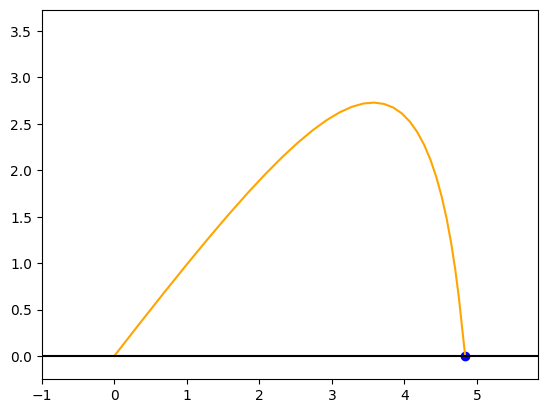

In [11]:

simul1.simulate()

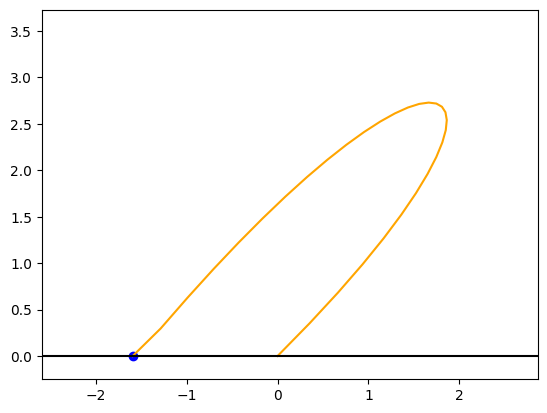

In [12]:
simul2.simulate()

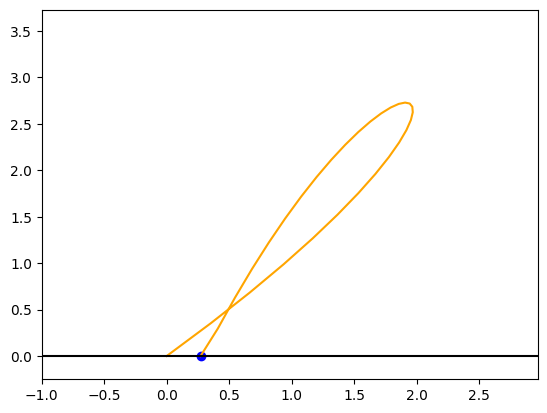

In [13]:
simul3.simulate()

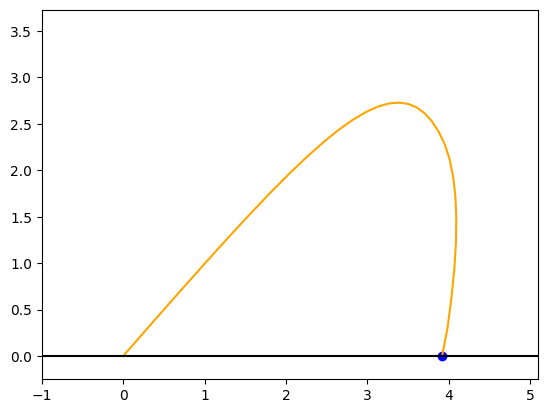

In [14]:
simul4.simulate()

The best part about this form of experiment is that since all the generic implementations can be written in `str` format which can be parsed, then one can create yaml files containing information regarding each and every one of the experiments.